In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Data

Consider a high-dimensional dataset, with 100 features, say, normally distributed with covariance $I_{100}$. We take a linear combination of the data (suppose it is simply a sum of the different features), and compute a non-linear function of it, say, cosine.

We wish to determine whether a neural network performs better at fitting the data compared to an SVM.

Later, on observing the performance on this dataset, we also consider data from a normal distribution but with a non-trivial covariance, which is dependent on w (100 * $1_{100}$), say, $I + w.w^T$.

In [2]:
DATA_SIZE = 10000
NUM_FEATURES = 25

In [3]:
from torch.distributions import MultivariateNormal
from sklearn.model_selection import train_test_split

### Uncorrelated

In [4]:
uncorrelated_distribution = MultivariateNormal(torch.zeros(NUM_FEATURES), torch.eye(NUM_FEATURES))

In [5]:
X_uncorrelated = uncorrelated_distribution.sample((DATA_SIZE,))
X_uncorrelated.shape

torch.Size([10000, 25])

In [6]:
# X_sum_sorted = torch.sort(X_uncorrelated.sum(dim=1)).values
# index_5_percent = int(0.05 * len(X_uncorrelated))
# scale_factor = torch.max(torch.abs(X_sum_sorted[index_5_percent]), torch.abs(X_sum_sorted[-index_5_percent])) / torch.max(X_sum_sorted)
scale_factor = 5 * torch.pi / torch.max(torch.abs(X_uncorrelated.sum(dim=1)))
# scale_factor = 1.
scale_factor

tensor(0.7429)

In [7]:
X_uncorrelated_scaled = X_uncorrelated * scale_factor

In [8]:
Y_uncorrelated = torch.cos(X_uncorrelated_scaled.sum(dim=1)).reshape(-1, 1) + torch.randn(len(X_uncorrelated), 1) * 0.05
Y_uncorrelated.shape

torch.Size([10000, 1])

Text(0, 0.5, 'Y')

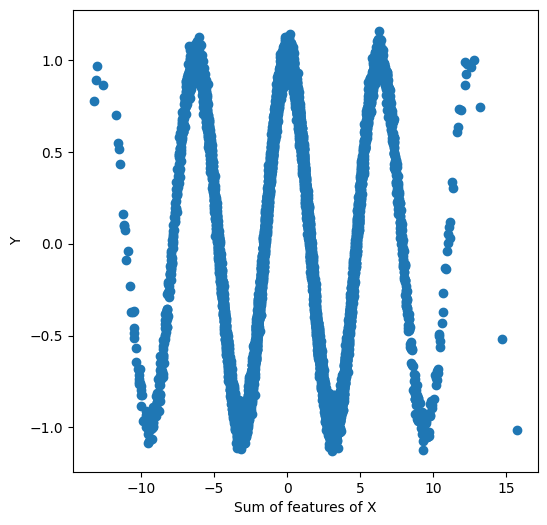

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(X_uncorrelated_scaled.sum(dim=1), Y_uncorrelated)
plt.xlabel('Sum of features of X')
plt.ylabel('Y')

In [10]:
X_training, X_test, Y_training, Y_test = train_test_split(X_uncorrelated_scaled, Y_uncorrelated, test_size=1000)
X_train, X_val, Y_train, Y_val = train_test_split(X_training, Y_training, test_size=1000)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([8000, 25]),
 torch.Size([8000, 1]),
 torch.Size([1000, 25]),
 torch.Size([1000, 1]),
 torch.Size([1000, 25]),
 torch.Size([1000, 1]))

In [11]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, 32, True), make_dataloader(X_val, Y_val, 32, True)

## Models

### Neural network

In [12]:
device = 'cpu'

In [13]:
depths = [1, 2, 3, 4]
widths = [16, 32, 64]
activations = [torch.nn.ReLU(), torch.nn.Tanh()]
etas = [1e-4, 1e-3, 1e-2]
weight_decays = np.logspace(-4, 4, 9).tolist()
weight_decays.append(0.0)
# betass = [(0.9, 0.999), (0.8, 0.9), (0., 0.)]

In [14]:
best_score = -torch.inf
best_depth = None
best_width = None
best_activation = None
best_eta = None
best_weight_decay = None
# best_betas = None

In [15]:
from scripts.train import train_model
from scripts.models import SimpleNN
from scripts.metrics import NegMeanSquaredError

total_count = len(depths) * len(widths) * len(activations) * len(etas) * len(weight_decays)
curr_count = 0
EPOCHS = 10
print(f'Cross validating across {total_count} models.\n')

for depth in depths:
    for width in widths:
        for activation in activations:
            for eta in etas:
                for weight_decay in weight_decays:
                        curr_count += 1
                        model = SimpleNN(NUM_FEATURES, activation=activation, task_type='regression', hidden_layers=depth, hidden_units=width).to(device)
                        history = train_model(
                            model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=val_dataloader,
                            loss_fn=torch.nn.MSELoss(),
                            optimizer=torch.optim.Adam(params=model.parameters(), lr=eta, weight_decay=weight_decay),
                            metric=NegMeanSquaredError(),
                            epochs=EPOCHS,
                            verbose=0,
                            device=device
                        )
                        curr_score = history['val_score'][-1]
                        if curr_score > best_score:
                            best_score = curr_score
                            best_depth = depth
                            best_width = width
                            best_activation = activation
                            best_eta = eta
                            best_weight_decay = weight_decay
                        print(f'[{curr_count}/{total_count}]\tDepth:{depth}, Width:{width}, Actn.:{activation}, lr:{eta}, w_d:{weight_decay} => Score:{curr_score:.6f}')

print(f'\nBest validation score after {EPOCHS} epochs: {best_score:.6f}. Best configuration:')
print(f'Depth:{best_depth}, Width:{best_width}, Actn.:{best_activation}, lr:{best_eta}, w_d:{best_weight_decay}')

Cross validating across 720 models.

[1/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.0001 => Score:-0.492867
[2/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.001 => Score:-0.487493
[3/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.01 => Score:-0.483770
[4/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.1 => Score:-0.485342
[5/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:1.0 => Score:-0.491549
[6/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:10.0 => Score:-0.484619
[7/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:100.0 => Score:-0.479568
[8/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:1000.0 => Score:-0.481702
[9/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:10000.0 => Score:-0.483823
[10/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.0001, w_d:0.0 => Score:-0.487236
[11/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.001, w_d:0.0001 => Score:-0.489096
[12/720]	Depth:1, Width:16, Actn.:ReLU(), lr:0.001, w_d:0.001 => Score:-0.

In [16]:
from scripts.models import SimpleNN

best_model_nn = SimpleNN(NUM_FEATURES, activation=best_activation, hidden_layers=best_depth, hidden_units=best_width, task_type='regression').to(device)

In [17]:
from scripts.metrics import NegMeanSquaredError
from scripts.utils import EarlyStopping

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=best_model_nn.parameters(), lr=best_eta, weight_decay=best_weight_decay)
metric = NegMeanSquaredError()
early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [18]:
from scripts.train import train_model

history = train_model(
    model=best_model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.503751, Train score: -0.503751, Val loss: 0.486524, Val score: -0.486524
Epoch: 2 => Train loss: 0.501186, Train score: -0.501186, Val loss: 0.490334, Val score: -0.490334
Epoch: 3 => Train loss: 0.500750, Train score: -0.500750, Val loss: 0.491505, Val score: -0.491505
Epoch: 4 => Train loss: 0.499142, Train score: -0.499142, Val loss: 0.484004, Val score: -0.484004
Epoch: 5 => Train loss: 0.495555, Train score: -0.495555, Val loss: 0.490589, Val score: -0.490589
Epoch: 6 => Train loss: 0.491643, Train score: -0.491643, Val loss: 0.493678, Val score: -0.493678
Epoch: 7 => Train loss: 0.485815, Train score: -0.485815, Val loss: 0.495172, Val score: -0.495172
Epoch: 8 => Train loss: 0.477382, Train score: -0.477382, Val loss: 0.501642, Val score: -0.501642
Epoch: 9 => Train loss: 0.470164, Train score: -0.470164, Val loss: 0.515685, Val score: -0.515685
Epoch: 10 => Train loss: 0.462777, Train score: -0.462

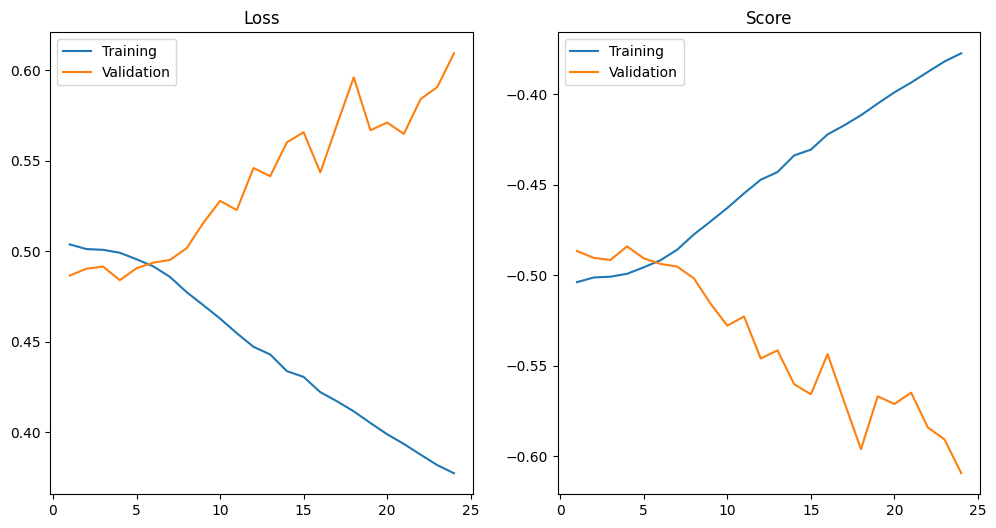

In [19]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [20]:
from scripts.test import predict

preds_train_nn, preds_val_nn = predict(best_model_nn, X_train, device), predict(best_model_nn, X_val, device)
preds_train_nn.shape, preds_val_nn.shape

(torch.Size([8000, 1]), torch.Size([1000, 1]))

Text(0.5, 0.98, 'NN')

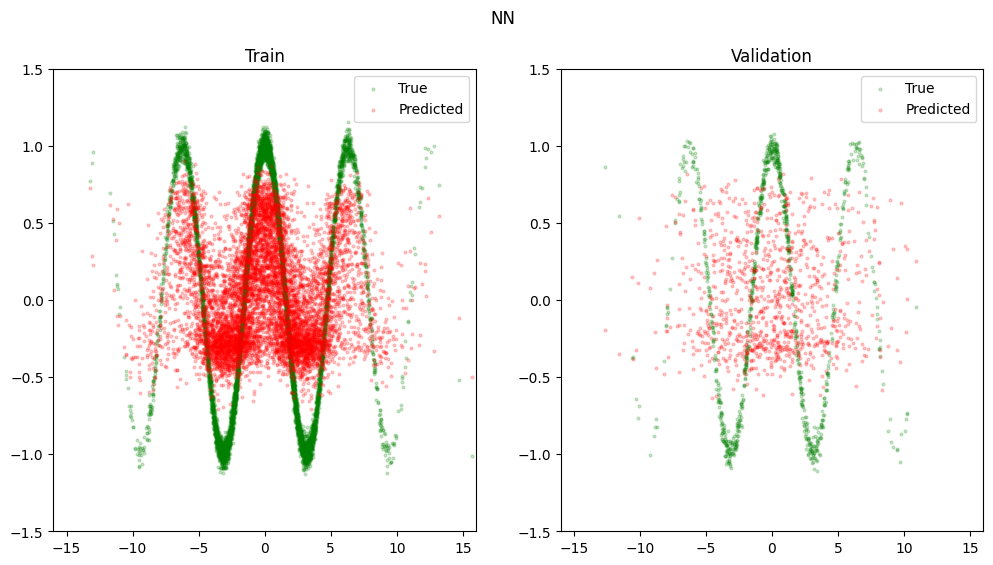

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_train.sum(dim=1), Y_train, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_train.sum(dim=1), preds_train_nn, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Train')
plt.xlim(-16, 16)
plt.ylim(-1.5, 1.5)
plt.legend()

plt.subplot(122)
plt.scatter(X_val.sum(dim=1), Y_val, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_val.sum(dim=1), preds_val_nn, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Validation')
plt.xlim(-16, 16)
plt.ylim(-1.5, 1.5)
plt.legend()

plt.suptitle('NN')

### SVM

In [26]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [27]:
ntk = NTK(best_model_nn).get_ntk

In [28]:
model_base_ntk = SVR(kernel=ntk, max_iter=int(1e4))
params_ntk = {
    'C': np.logspace(-4, 4, 9)
}

gammas = np.logspace(-4, 4, 9).tolist()
gammas.append('scale')
gammas.append('auto')
model_base_rbf = SVR(kernel='rbf', max_iter=int(1e4))
params_rbf = {
    'C': np.logspace(-4, 4, 9),
    'gamma': gammas
}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [29]:
model_cv_ntk = GridSearchCV(
    estimator=model_base_ntk,
    param_grid=params_ntk,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_ntk.fit(X_train, Y_train.squeeze())
best_params_ntk = model_cv_ntk.best_params_
best_score_ntk = max(model_cv_ntk.cv_results_['mean_test_score'])
best_params_ntk, best_score_ntk

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 3/5] END .........................C=0.0001;, score=-0.413 total time=  20.9s
[CV 5/5] END .........................C=0.0001;, score=-0.423 total time=  21.2s
[CV 1/5] END .........................C=0.0001;, score=-0.405 total time=  21.3s
[CV 2/5] END .........................C=0.0001;, score=-0.415 total time=  21.4s
[CV 4/5] END .........................C=0.0001;, score=-0.396 total time=  21.6s
[CV 2/5] END ..........................C=0.001;, score=-0.370 total time=  21.8s
[CV 1/5] END ..........................C=0.001;, score=-0.368 total time=  22.3s
[CV 3/5] END ..........................C=0.001;, score=-0.382 total time=  22.2s
[CV 4/5] END ..........................C=0.001;, score=-0.350 total time=  22.3s
[CV 5/5] END ..........................C=0.001;, score=-0.397 total time=  22.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 1/5] END ...........................C=0.01;, score=-0.423 total time=  21.4s
[CV 2/5] END ...........................C=0.01;, score=-0.443 total time=  22.7s
[CV 4/5] END ...........................C=0.01;, score=-0.407 total time=  22.7s
[CV 3/5] END ...........................C=0.01;, score=-0.456 total time=  22.9s
[CV 5/5] END ...........................C=0.01;, score=-0.471 total time=  22.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 1/5] END ............................C=0.1;, score=-0.606 total time=  22.1s
[CV 2/5] END ............................C=0.1;, score=-0.648 total time=  22.2s
[CV 4/5] END ............................C=0.1;, score=-0.592 total time=  22.9s
[CV 3/5] END ............................C=0.1;, score=-0.659 total time=  23.2s
[CV 5/5] END ............................C=0.1;, score=-0.665 total time=  23.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 1/5] END ............................C=1.0;, score=-1.027 total time=  20.5s
[CV 3/5] END ............................C=1.0;, score=-1.194 total time=  22.2s
[CV 2/5] END ............................C=1.0;, score=-1.077 total time=  23.7s
[CV 4/5] END ............................C=1.0;, score=-1.152 total time=  22.8s
[CV 5/5] END ............................C=1.0;, score=-1.534 total time=  22.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........................C=10.0;, score=-1.581 total time=  20.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ...........................C=10.0;, score=-1.569 total time=  22.0s
[CV 3/5] END ...........................C=10.0;, score=-1.519 total time=  22.7s
[CV 4/5] END ...........................C=10.0;, score=-1.700 total time=  22.9s
[CV 5/5] END ...........................C=10.0;, score=-1.774 total time=  23.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..........................C=100.0;, score=-1.720 total time=  21.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..........................C=100.0;, score=-1.482 total time=  22.0s
[CV 4/5] END ..........................C=100.0;, score=-1.364 total time=  22.2s
[CV 3/5] END ..........................C=100.0;, score=-1.283 total time=  23.2s
[CV 5/5] END ..........................C=100.0;, score=-1.454 total time=  22.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .........................C=1000.0;, score=-1.720 total time=  20.9s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .........................C=1000.0;, score=-1.482 total time=  21.7s
[CV 5/5] END .........................C=1000.0;, score=-1.454 total time=  20.9s
[CV 4/5] END .........................C=1000.0;, score=-1.364 total time=  22.1s
[CV 3/5] END .........................C=1000.0;, score=-1.283 total time=  22.8s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ........................C=10000.0;, score=-1.720 total time=  21.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ........................C=10000.0;, score=-1.482 total time=  21.5s
[CV 3/5] END ........................C=10000.0;, score=-1.283 total time=  21.2s
[CV 4/5] END ........................C=10000.0;, score=-1.364 total time=  21.1s
[CV 5/5] END ........................C=10000.0;, score=-1.454 total time=  21.0s


({'C': 0.001}, -0.3735301873517549)

In [30]:
model_cv_rbf = GridSearchCV(
    estimator=model_base_rbf,
    param_grid=params_rbf,
    scoring=scorer,
    n_jobs=5,
    refit=False,
    verbose=3
)
model_cv_rbf.fit(X_train, Y_train.squeeze())
best_params_rbf = model_cv_rbf.best_params_
best_score_rbf = max(model_cv_rbf.cv_results_['mean_test_score'])
best_params_rbf, best_score_rbf

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 4/5] END ...........C=0.0001, gamma=0.0001;, score=-0.492 total time=   2.8s
[CV 1/5] END ...........C=0.0001, gamma=0.0001;, score=-0.494 total time=   2.9s
[CV 2/5] END ...........C=0.0001, gamma=0.0001;, score=-0.514 total time=   2.9s
[CV 5/5] END ...........C=0.0001, gamma=0.0001;, score=-0.504 total time=   2.9s
[CV 3/5] END ...........C=0.0001, gamma=0.0001;, score=-0.501 total time=   2.9s
[CV 2/5] END ............C=0.0001, gamma=0.001;, score=-0.514 total time=   2.9s
[CV 4/5] END ............C=0.0001, gamma=0.001;, score=-0.492 total time=   2.9s
[CV 3/5] END ............C=0.0001, gamma=0.001;, score=-0.501 total time=   3.0s
[CV 5/5] END ............C=0.0001, gamma=0.001;, score=-0.504 total time=   2.9s
[CV 1/5] END ............C=0.0001, gamma=0.001;, score=-0.494 total time=   3.0s
[CV 1/5] END .............C=0.0001, gamma=0.01;, score=-0.494 total time=   2.9s
[CV 3/5] END .............C=0.0001, gamma=0.01;

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .................C=1.0, gamma=0.1;, score=-0.574 total time=   3.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END .................C=1.0, gamma=0.1;, score=-0.588 total time=   3.3s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .................C=1.0, gamma=0.1;, score=-0.569 total time=   3.3s
[CV 4/5] END .................C=1.0, gamma=0.1;, score=-0.546 total time=   3.4s
[CV 5/5] END .................C=1.0, gamma=0.1;, score=-0.595 total time=   3.4s
[CV 1/5] END .................C=1.0, gamma=1.0;, score=-0.494 total time=   3.4s
[CV 2/5] END .................C=1.0, gamma=1.0;, score=-0.514 total time=   3.3s
[CV 3/5] END .................C=1.0, gamma=1.0;, score=-0.501 total time=   3.5s
[CV 4/5] END .................C=1.0, gamma=1.0;, score=-0.492 total time=   3.5s
[CV 5/5] END .................C=1.0, gamma=1.0;, score=-0.504 total time=   3.4s
[CV 1/5] END ................C=1.0, gamma=10.0;, score=-0.494 total time=   3.4s
[CV 2/5] END ................C=1.0, gamma=10.0;, score=-0.514 total time=   3.3s
[CV 3/5] END ................C=1.0, gamma=10.0;, score=-0.501 total time=   3.6s
[CV 4/5] END ................C=1.0, gamma=10.0;, score=-0.492 total time=   3.5s
[CV 5/5] END ...............

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=10.0, gamma=0.01;, score=-0.552 total time=   3.7s
[CV 2/5] END ...............C=10.0, gamma=0.01;, score=-0.568 total time=   3.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=10.0, gamma=0.01;, score=-0.562 total time=   3.6s
[CV 4/5] END ...............C=10.0, gamma=0.01;, score=-0.541 total time=   3.6s
[CV 5/5] END ...............C=10.0, gamma=0.01;, score=-0.583 total time=   3.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ................C=10.0, gamma=0.1;, score=-0.661 total time=   3.6s
[CV 2/5] END ................C=10.0, gamma=0.1;, score=-0.649 total time=   3.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ................C=10.0, gamma=0.1;, score=-0.620 total time=   3.5s
[CV 3/5] END ................C=10.0, gamma=0.1;, score=-0.643 total time=   3.6s
[CV 5/5] END ................C=10.0, gamma=0.1;, score=-0.664 total time=   3.6s
[CV 2/5] END ................C=10.0, gamma=1.0;, score=-0.514 total time=   3.2s
[CV 1/5] END ................C=10.0, gamma=1.0;, score=-0.494 total time=   3.4s
[CV 3/5] END ................C=10.0, gamma=1.0;, score=-0.501 total time=   3.5s
[CV 4/5] END ................C=10.0, gamma=1.0;, score=-0.492 total time=   3.6s
[CV 5/5] END ................C=10.0, gamma=1.0;, score=-0.504 total time=   3.5s
[CV 2/5] END ...............C=10.0, gamma=10.0;, score=-0.514 total time=   3.4s
[CV 1/5] END ...............C=10.0, gamma=10.0;, score=-0.494 total time=   3.6s
[CV 3/5] END ...............C=10.0, gamma=10.0;, score=-0.501 total time=   3.5s
[CV 4/5] END ...............C=10.0, gamma=10.0;, score=-0.492 total time=   3.5s
[CV 5/5] END ...............

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=10.0, gamma=scale;, score=-0.693 total time=   3.5s
[CV 2/5] END ..............C=10.0, gamma=scale;, score=-0.685 total time=   3.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=10.0, gamma=scale;, score=-0.664 total time=   3.5s
[CV 4/5] END ..............C=10.0, gamma=scale;, score=-0.644 total time=   3.5s
[CV 5/5] END ..............C=10.0, gamma=scale;, score=-0.694 total time=   3.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=10.0, gamma=auto;, score=-0.661 total time=   3.4s
[CV 2/5] END ...............C=10.0, gamma=auto;, score=-0.667 total time=   3.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=10.0, gamma=auto;, score=-0.632 total time=   3.4s
[CV 4/5] END ...............C=10.0, gamma=auto;, score=-0.611 total time=   3.4s
[CV 5/5] END ...............C=10.0, gamma=auto;, score=-0.674 total time=   3.4s
[CV 1/5] END ............C=100.0, gamma=0.0001;, score=-0.499 total time=   2.9s
[CV 2/5] END ............C=100.0, gamma=0.0001;, score=-0.524 total time=   2.9s
[CV 3/5] END ............C=100.0, gamma=0.0001;, score=-0.510 total time=   3.0s
[CV 4/5] END ............C=100.0, gamma=0.0001;, score=-0.497 total time=   2.9s
[CV 5/5] END ............C=100.0, gamma=0.0001;, score=-0.513 total time=   3.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=100.0, gamma=0.001;, score=-0.511 total time=   3.7s
[CV 2/5] END .............C=100.0, gamma=0.001;, score=-0.535 total time=   3.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=100.0, gamma=0.001;, score=-0.523 total time=   3.6s
[CV 4/5] END .............C=100.0, gamma=0.001;, score=-0.507 total time=   3.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END .............C=100.0, gamma=0.001;, score=-0.525 total time=   3.6s
[CV 1/5] END ..............C=100.0, gamma=0.01;, score=-0.661 total time=   2.7s
[CV 2/5] END ..............C=100.0, gamma=0.01;, score=-0.641 total time=   2.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=100.0, gamma=0.01;, score=-0.643 total time=   2.7s
[CV 4/5] END ..............C=100.0, gamma=0.01;, score=-0.607 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ..............C=100.0, gamma=0.01;, score=-0.611 total time=   2.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...............C=100.0, gamma=0.1;, score=-0.662 total time=   3.6s
[CV 2/5] END ...............C=100.0, gamma=0.1;, score=-0.654 total time=   3.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ...............C=100.0, gamma=0.1;, score=-0.651 total time=   3.6s
[CV 4/5] END ...............C=100.0, gamma=0.1;, score=-0.624 total time=   3.6s
[CV 5/5] END ...............C=100.0, gamma=0.1;, score=-0.670 total time=   3.6s
[CV 2/5] END ...............C=100.0, gamma=1.0;, score=-0.514 total time=   3.4s
[CV 1/5] END ...............C=100.0, gamma=1.0;, score=-0.494 total time=   3.6s
[CV 3/5] END ...............C=100.0, gamma=1.0;, score=-0.501 total time=   3.5s
[CV 4/5] END ...............C=100.0, gamma=1.0;, score=-0.492 total time=   3.5s
[CV 5/5] END ...............C=100.0, gamma=1.0;, score=-0.504 total time=   3.4s
[CV 2/5] END ..............C=100.0, gamma=10.0;, score=-0.514 total time=   3.4s
[CV 1/5] END ..............C=100.0, gamma=10.0;, score=-0.494 total time=   3.5s
[CV 3/5] END ..............C=100.0, gamma=10.0;, score=-0.501 total time=   3.5s
[CV 4/5] END ..............C=100.0, gamma=10.0;, score=-0.492 total time=   3.5s
[CV 5/5] END ..............C

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=100.0, gamma=scale;, score=-0.710 total time=   3.5s
[CV 2/5] END .............C=100.0, gamma=scale;, score=-0.694 total time=   3.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=100.0, gamma=scale;, score=-0.667 total time=   3.4s
[CV 3/5] END .............C=100.0, gamma=scale;, score=-0.693 total time=   3.4s
[CV 5/5] END .............C=100.0, gamma=scale;, score=-0.708 total time=   3.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END ..............C=100.0, gamma=auto;, score=-0.713 total time=   2.9s
[CV 1/5] END ..............C=100.0, gamma=auto;, score=-0.732 total time=   3.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=100.0, gamma=auto;, score=-0.694 total time=   3.0s
[CV 4/5] END ..............C=100.0, gamma=auto;, score=-0.681 total time=   3.0s
[CV 5/5] END ..............C=100.0, gamma=auto;, score=-0.718 total time=   3.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=1000.0, gamma=0.0001;, score=-0.504 total time=   3.7s
[CV 2/5] END ...........C=1000.0, gamma=0.0001;, score=-0.525 total time=   3.7s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 3/5] END ...........C=1000.0, gamma=0.0001;, score=-0.513 total time=   3.7s
[CV 4/5] END ...........C=1000.0, gamma=0.0001;, score=-0.497 total time=   3.7s
[CV 5/5] END ...........C=1000.0, gamma=0.0001;, score=-0.516 total time=   3.7s
[CV 1/5] END ............C=1000.0, gamma=0.001;, score=-0.617 total time=   2.6s
[CV 2/5] END ............C=1000.0, gamma=0.001;, score=-0.704 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 3/5] END ............C=1000.0, gamma=0.001;, score=-0.628 total time=   2.6s
[CV 4/5] END ............C=1000.0, gamma=0.001;, score=-0.621 total time=   2.5s
[CV 5/5] END ............C=1000.0, gamma=0.001;, score=-0.713 total time=   2.6s
[CV 1/5] END .............C=1000.0, gamma=0.01;, score=-0.642 total time=   2.6s
[CV 2/5] END .............C=1000.0, gamma=0.01;, score=-0.639 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END .............C=1000.0, gamma=0.01;, score=-0.694 total time=   2.6s
[CV 4/5] END .............C=1000.0, gamma=0.01;, score=-0.674 total time=   2.6s
[CV 5/5] END .............C=1000.0, gamma=0.01;, score=-0.688 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ..............C=1000.0, gamma=0.1;, score=-0.662 total time=   3.6s
[CV 2/5] END ..............C=1000.0, gamma=0.1;, score=-0.654 total time=   3.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ..............C=1000.0, gamma=0.1;, score=-0.651 total time=   3.6s
[CV 4/5] END ..............C=1000.0, gamma=0.1;, score=-0.624 total time=   3.6s
[CV 5/5] END ..............C=1000.0, gamma=0.1;, score=-0.670 total time=   3.6s
[CV 2/5] END ..............C=1000.0, gamma=1.0;, score=-0.514 total time=   3.3s
[CV 1/5] END ..............C=1000.0, gamma=1.0;, score=-0.494 total time=   3.6s
[CV 5/5] END ..............C=1000.0, gamma=1.0;, score=-0.504 total time=   3.4s
[CV 3/5] END ..............C=1000.0, gamma=1.0;, score=-0.501 total time=   3.5s
[CV 4/5] END ..............C=1000.0, gamma=1.0;, score=-0.492 total time=   3.5s
[CV 1/5] END .............C=1000.0, gamma=10.0;, score=-0.494 total time=   3.5s
[CV 2/5] END .............C=1000.0, gamma=10.0;, score=-0.514 total time=   3.4s
[CV 5/5] END .............C=1000.0, gamma=10.0;, score=-0.504 total time=   3.5s
[CV 3/5] END .............C=1000.0, gamma=10.0;, score=-0.501 total time=   3.6s
[CV 4/5] END .............C=

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ............C=1000.0, gamma=scale;, score=-0.710 total time=   3.4s
[CV 2/5] END ............C=1000.0, gamma=scale;, score=-0.694 total time=   3.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END ............C=1000.0, gamma=scale;, score=-0.667 total time=   3.4s
[CV 3/5] END ............C=1000.0, gamma=scale;, score=-0.693 total time=   3.4s
[CV 5/5] END ............C=1000.0, gamma=scale;, score=-0.708 total time=   3.4s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=1000.0, gamma=auto;, score=-0.723 total time=   3.0s
[CV 2/5] END .............C=1000.0, gamma=auto;, score=-0.717 total time=   3.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 1/5] END ..........C=10000.0, gamma=0.0001;, score=-0.693 total time=   2.5s
[CV 3/5] END .............C=1000.0, gamma=auto;, score=-0.704 total time=   3.0s
[CV 4/5] END .............C=1000.0, gamma=auto;, score=-0.666 total time=   3.0s
[CV 5/5] END .............C=1000.0, gamma=auto;, score=-0.727 total time=   3.0s
[CV 2/5] END ..........C=10000.0, gamma=0.0001;, score=-0.618 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 3/5] END ..........C=10000.0, gamma=0.0001;, score=-0.630 total time=   2.6s
[CV 2/5] END ...........C=10000.0, gamma=0.001;, score=-0.798 total time=   2.4s
[CV 1/5] END ...........C=10000.0, gamma=0.001;, score=-0.733 total time=   2.5s
[CV 4/5] END ..........C=10000.0, gamma=0.0001;, score=-0.663 total time=   2.6s
[CV 5/5] END ..........C=10000.0, gamma=0.0001;, score=-0.625 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 3/5] END ...........C=10000.0, gamma=0.001;, score=-0.654 total time=   2.5s
[CV 4/5] END ...........C=10000.0, gamma=0.001;, score=-0.741 total time=   2.4s
[CV 5/5] END ...........C=10000.0, gamma=0.001;, score=-0.736 total time=   2.4s
[CV 2/5] END ............C=10000.0, gamma=0.01;, score=-0.639 total time=   2.5s
[CV 1/5] END ............C=10000.0, gamma=0.01;, score=-0.642 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END ............C=10000.0, gamma=0.01;, score=-0.694 total time=   2.6s
[CV 4/5] END ............C=10000.0, gamma=0.01;, score=-0.674 total time=   2.5s
[CV 5/5] END ............C=10000.0, gamma=0.01;, score=-0.688 total time=   2.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END .............C=10000.0, gamma=0.1;, score=-0.662 total time=   3.6s
[CV 2/5] END .............C=10000.0, gamma=0.1;, score=-0.654 total time=   3.6s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END .............C=10000.0, gamma=0.1;, score=-0.624 total time=   3.5s
[CV 3/5] END .............C=10000.0, gamma=0.1;, score=-0.651 total time=   3.6s
[CV 5/5] END .............C=10000.0, gamma=0.1;, score=-0.670 total time=   3.5s
[CV 2/5] END .............C=10000.0, gamma=1.0;, score=-0.514 total time=   3.4s
[CV 1/5] END .............C=10000.0, gamma=1.0;, score=-0.494 total time=   3.5s
[CV 5/5] END .............C=10000.0, gamma=1.0;, score=-0.504 total time=   3.5s
[CV 4/5] END .............C=10000.0, gamma=1.0;, score=-0.492 total time=   3.6s
[CV 3/5] END .............C=10000.0, gamma=1.0;, score=-0.501 total time=   3.6s
[CV 2/5] END ............C=10000.0, gamma=10.0;, score=-0.514 total time=   3.6s
[CV 1/5] END ............C=10000.0, gamma=10.0;, score=-0.494 total time=   3.8s
[CV 5/5] END ............C=10000.0, gamma=10.0;, score=-0.504 total time=   3.5s
[CV 4/5] END ............C=10000.0, gamma=10.0;, score=-0.492 total time=   3.7s
[CV 3/5] END ............C=1

/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END ...........C=10000.0, gamma=scale;, score=-0.710 total time=   3.4s
[CV 2/5] END ...........C=10000.0, gamma=scale;, score=-0.694 total time=   3.5s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base

[CV 3/5] END ...........C=10000.0, gamma=scale;, score=-0.693 total time=   3.4s
[CV 5/5] END ...........C=10000.0, gamma=scale;, score=-0.708 total time=   3.4s
[CV 4/5] END ...........C=10000.0, gamma=scale;, score=-0.667 total time=   3.4s
[CV 1/5] END ............C=10000.0, gamma=auto;, score=-0.723 total time=   3.0s
[CV 2/5] END ............C=10000.0, gamma=auto;, score=-0.717 total time=   3.0s


/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/balakrishnan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END ............C=10000.0, gamma=auto;, score=-0.727 total time=   2.5s
[CV 4/5] END ............C=10000.0, gamma=auto;, score=-0.666 total time=   2.5s
[CV 3/5] END ............C=10000.0, gamma=auto;, score=-0.704 total time=   2.6s


({'C': 10.0, 'gamma': 10.0}, -0.5008526719974394)

In [31]:
if best_score_ntk >= best_score_rbf:
    best_model_km = SVR(kernel=ntk, C=best_params_ntk['C'])
else:
    best_model_km = SVR(C=best_params_rbf['C'], gamma=best_params_rbf['gamma'])

In [32]:
best_model_km.fit(X_train, Y_train.squeeze())

SVR(C=0.001,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7efb88302d10>>)

In [33]:
preds_train_km, preds_val_km = best_model_km.predict(X_train), best_model_km.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train_km), mean_squared_error(Y_val, preds_val_km)
score_train, score_val

(0.34157757166111274, 0.7055515226482749)

Text(0.5, 0.98, 'SVM')

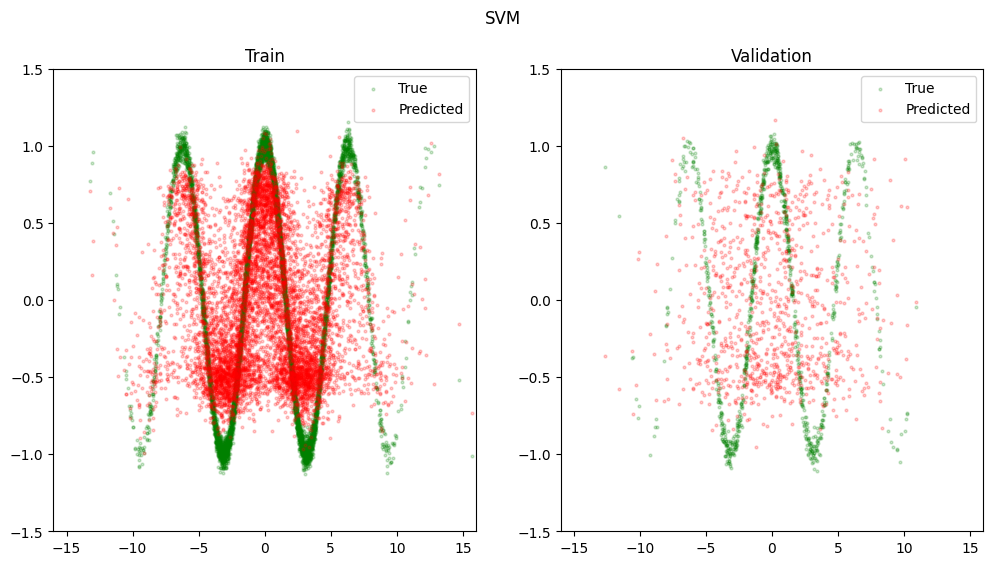

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(X_train.sum(dim=1), Y_train, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_train.sum(dim=1), preds_train_km, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Train')
plt.xlim(-16, 16)
plt.ylim(-1.5, 1.5)
plt.legend()

plt.subplot(122)
plt.scatter(X_val.sum(dim=1), Y_val, c='g', label='True', s=4, alpha=0.2)
plt.scatter(X_val.sum(dim=1), preds_val_km, c='r', label='Predicted', s=4, alpha=0.2)
plt.title('Validation')
plt.xlim(-16, 16)
plt.ylim(-1.5, 1.5)
plt.legend()

plt.suptitle('SVM')